# Assignment — Power Law

In [1]:
from typing import List
from zlib import adler32
import networkx as nx
import requests
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Task 1. Power law CDF (1 points)

Scale-free network has a Power law degree distribution. Let us take a closer look at this distribution. The PDF of the Power law is 

$$ p(x) = Cx^{-\alpha},$$ 

where $C$ is a normalization constant 

$$C = \frac{\alpha - 1}{x_{\text{min}}^{-\alpha + 1}}$$ 

and $\alpha>1$ is called an exponent of the distribution. 

In [2]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

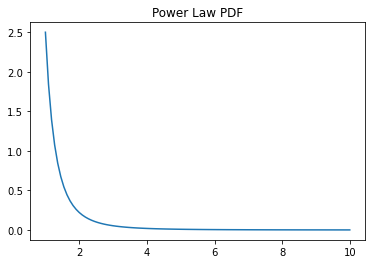

In [3]:
x_space = np.linspace(1, 10, 100)
plt.plot(x_space, power_law_pdf(x_space))
plt.title('Power Law PDF');

Let us generate observations from a Power Law RV. The first step is to derive CDF of Powel law: $F(x) = P(X \leq x)$

$$F(x) = 1 - \int_{x}^\infty p(t) dt.$$

Take the integral, derive CDF analytically and then write a function `power_law_cdf` with parameters `x`, `alpha` and `x_min`.

In [4]:
def power_law_cdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return 1 + C * x ** (1 - alpha) / (1 - alpha)
    raise NotImplementedError()

In [5]:
assert power_law_cdf(2, 2, 1) == 0.5
assert power_law_cdf(10, 2, 1) == 0.9
assert adler32(str(power_law_cdf(2, 3, 1)).encode()) == 32571595

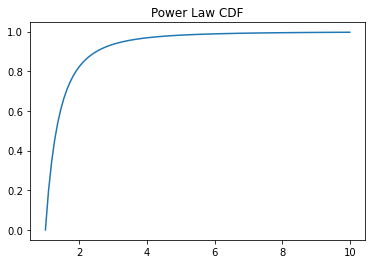

In [6]:
x_space = np.linspace(1, 10, 100)
plt.plot(x_space, power_law_cdf(x_space))
plt.title('Power Law CDF');

### Task 2. Power law PPF (1 points)

Let $X \sim \text{Power law}$. Next, define a random variable $R$, s.t. $R = F(X)$, so $R$ will be uniformly distributed on interval [0, 1] ([proof](https://en.wikipedia.org/wiki/Probability_integral_transform#Proof)). Good thing here is that we easily can generate uniformly distributed pseudorandom numbers and then transform them into Power Law. Let us find an expression for $x = F^{-1}(r)$, where $r$ is an observation from uniform distrubution on interval [0, 1]. 

Find an analytical form of $F^{-1}(r)$ and write a function `power_law_ppf` (percent point function, also known as a quantile) with parameters `r`, `alpha` and `x_min`. 

In [7]:
def power_law_ppf(r, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return ((1 - alpha) * (r - 1) / C) ** (1 / (1 - alpha))
    raise NotImplementedError()

In [8]:
assert round(power_law_ppf(0.5, 2, 1), 2) == 2
assert round(power_law_ppf(0.9, 2, 1), 2) == 10
assert adler32(str(round(power_law_ppf(0.96, 3, 1), 2)).encode()) == 19792020

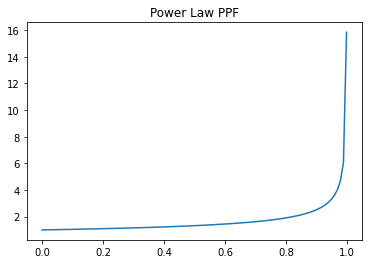

In [9]:
x_space = np.linspace(0, 0.999, 100)
plt.plot(x_space, power_law_ppf(x_space))
plt.title('Power Law PPF');

Finally, we can generate observation from Power law distribution as follows:
1. Generate observation from uniform distribution on interval [0, 1]
2. Calculate PPF value of given observation

In [10]:
def power_law_generate(n, alpha=3.5, x_min=1, random_seed=1):
    np.random.seed(random_seed)
    uni_sample = np.random.uniform(0, 0.999, n)
    return power_law_ppf(uni_sample, alpha, x_min)

Look at the histogram of the generated sample

In [11]:
alpha = 3.5
x_min = 1
x_train = power_law_generate(1000, alpha, x_min)
x_space = np.linspace(1, 15, 100)

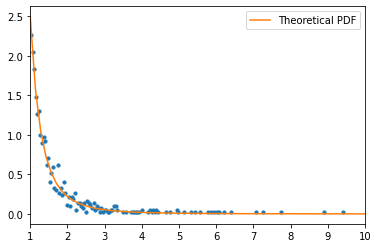

In [12]:
hist, bin_edges = np.histogram(x_train, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=10)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), 
         label='Theoretical PDF', c='tab:orange')
plt.legend()
plt.xlim(1, 10)
plt.show()

And here is the same histogram in log-log scale

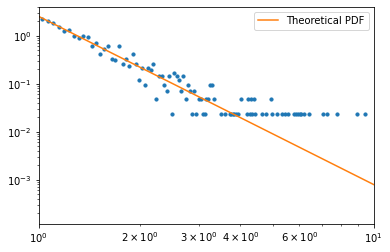

In [13]:
hist, bin_edges = np.histogram(x_train, bins=200, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)
plt.plot(x_space, power_law_pdf(x_space, alpha, x_min), 
         label='Theoretical PDF', c='tab:orange')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10)
plt.show()

### Task 3. Estimation of alpha with linear binning (2 points)

Given observations from the Power Law distribution, try to estimate $\alpha$. The easiest way is to draw an empirical PDF with linear binning in log-log scale and apply linear regression. By _linear binning_ we mean to keep a bin width is fixed.

Write a function `alpha_lin_bins` that takes a train set, number of linear bins and returns an estimated $\alpha$.

_Hints:_
* _Take log in both side of $p(x) = Cx^{-\alpha}$_
* _To calculate an empirical PDF, use `np.histogram(x_train, bins=bins, density=True)`_
* _To calculate pseudoinverse matrix, use `np.linalg.pinv`_
* _Also you can use fit-predict in `sklearn.linear.LinearRegression`_

In [135]:
from sklearn.linear_model import LinearRegression

def alpha_lin_bins(x_train, bins):
    histogram = np.histogram(x_train, bins=bins, density=True)
    X = np.log((histogram[1][1:] + histogram[1][:-1]) / 2)
    X = X[np.where(histogram[0] != 0)]
    X = X.reshape(-1, 1)
    y = np.log(histogram[0][np.where(histogram[0] != 0)])
    reg = LinearRegression()
    reg.fit(X, y)
    return np.abs(reg.coef_[0])
    raise NotImplementedError()

In [136]:
bins = 100
x_train = power_law_generate(1000, x_min=1, alpha=2)
assert np.abs(alpha_lin_bins(x_train, bins) - 2) < 0.7
x_train = power_law_generate(1000, x_min=1, alpha=3.5)
assert np.abs(alpha_lin_bins(x_train, bins) - 3.5) < 0.9
x_train = power_law_generate(1000, x_min=1, alpha=10)
assert np.abs(alpha_lin_bins(x_train, bins) - 10) < 2

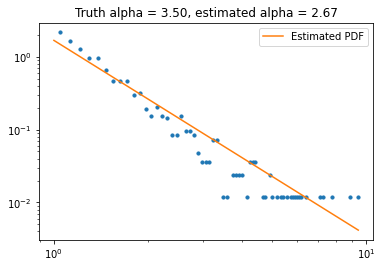

In [137]:
x_min = 1
alpha = 3.5
bins = 100

x_train = power_law_generate(1000, alpha, x_min)
hist, bin_edges = np.histogram(x_train, bins=bins, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers, hist, s=10)

hat_alpha = alpha_lin_bins(x_train, bins)
x_space = np.linspace(x_min, x_train.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, x_min), 
         label='Estimated PDF', c='tab:orange')
plt.legend()
plt.title('Truth alpha = {:.2f}, estimated alpha = {:.2f}'.format(alpha, hat_alpha))
plt.xscale('log')
plt.yscale('log')
plt.show()

### Task 4. Generation graphs with a given degree distribution (2 points)

In this task, we will try to guess a graph by its degree distribution.

__Graph A__ is described by the histogram `[0, 2, 10]` — 0 nodes with degree 0, 2 nodes with degree 1, 10 nodes with degree 2.

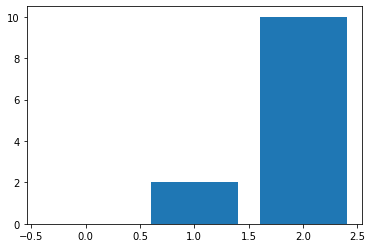

In [14]:
dens_a = [0, 2, 10]
plt.bar(range(len(dens_a)), dens_a);

In [15]:
def generate_graph_a() -> nx.Graph:
    edges = []
    for i in range(11):
        edges.append([i, i + 1])
    return nx.Graph(edges)
    raise NotImplementedError()

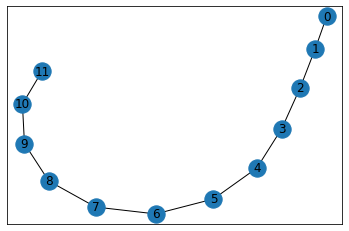

In [16]:
G = generate_graph_a()
assert nx.degree_histogram(G) == dens_a
assert nx.is_connected(G)
nx.draw_networkx(G)

__Graph B__

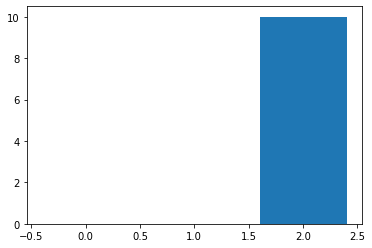

In [17]:
dens_b = [0, 0, 10]
plt.bar(range(len(dens_b)), dens_b);

In [18]:
def generate_graph_b() -> nx.Graph:
    edges = []
    for i in range(9):
        edges.append([i, i + 1])
    edges.append([0, 9])
    return nx.Graph(edges)
    raise NotImplementedError()

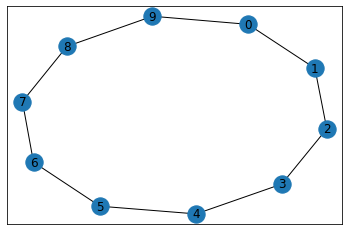

In [19]:
G = generate_graph_b()
assert nx.degree_histogram(G) == dens_b
assert nx.is_connected(G)
nx.draw_networkx(G)

__Graph C__

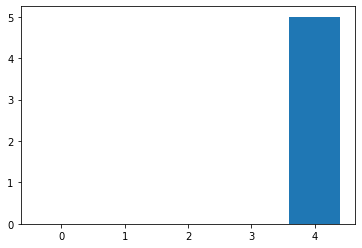

In [20]:
dens_c = [0, 0, 0, 0, 5]
plt.bar(range(len(dens_c)), dens_c);

In [21]:
def generate_graph_c() -> nx.Graph:
    return nx.complete_graph(5)
    raise NotImplementedError()

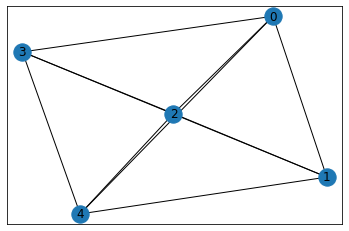

In [22]:
G = generate_graph_c()
assert nx.degree_histogram(G) == dens_c
assert nx.is_connected(G)
nx.draw_networkx(G)

__Graph D__

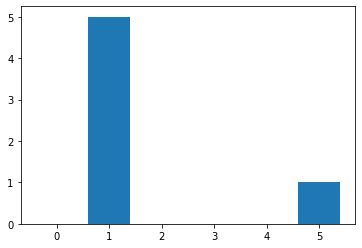

In [23]:
dens_d = [0, 5, 0, 0, 0, 1]
plt.bar(range(len(dens_d)), dens_d);

In [24]:
def generate_graph_d() -> nx.Graph:
    edges = []
    for i in range(5):
        edges.append([i, 5])
    return nx.Graph(edges)
    raise NotImplementedError()

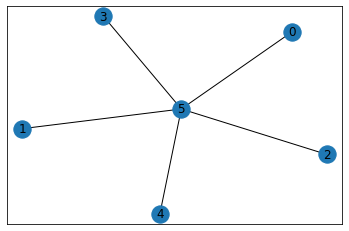

In [25]:
G = generate_graph_d()
assert nx.degree_histogram(G) == dens_d
assert nx.is_connected(G)
nx.draw_networkx(G)

### Task 5. MLE of alpha in Power Law (2 points)

Let us estimate $\alpha$ and $x_\min$ of a real social network using maximum likelihood. Here is a real degree distribution of the network of emails between members of the research institution with 1005 nodes.

In [30]:
url = 'https://raw.githubusercontent.com/network-science-course/network-science-course/main/datasets/email_degree_sequence.txt'
open('email_degree_sequence.txt', 'wb').write(requests.get(url).content);


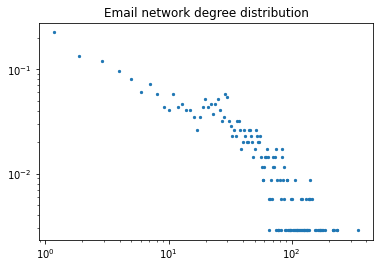

In [31]:
degree_sequence = np.loadtxt('email_degree_sequence.txt')
hist, bin_edges = np.histogram(degree_sequence, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Email network degree distribution')
plt.xscale('log')
plt.yscale('log')

The MLE consists of:
1. Fix $x_\min$ as a minimal node degree (drop node degrees that less than $x_\min$)
2. Calculate $\alpha$ via maximum likelihood estimation using fixed $x_\min$
$$\alpha = 1 + n \left[\sum_i \log \frac{x_i}{x_\min} \right]^{-1}$$
3. Calculate Kolmogorov-Smirnov test
4. Fix $x_\min$ as the next node degree
5. Repeat 2-4 by scanning all possible $x_\min$ and find the best $\alpha$ and $x_\min$ with respect to Kolmogorov-Smirnov test

Write a function `ml_power_law_params` that takes a node degree sequence `degree_sequence` and returns a tuple of two values: the best $\alpha$ and $x_\min$.

_Hints:_
* _To calculate Kolmogorov-Smirnov distance use `scipy.stats.kstest` with a parameter `cdf=power_law_cdf`_

In [117]:
from scipy.stats import kstest

def mle_power_law_params(degree_sequence):
    x_min_opt = -1
    alpha_opt = 0
    kstest_min = np.inf
    ds_unique = np.unique(degree_sequence)
    for x in ds_unique:
        arr = np.array(degree_sequence[degree_sequence >= int(x)])
        n = len(arr)
        S = np.sum(np.log(arr / x))
        if S <= 0:
            break
        alpha = 1 + n / S
        kstest_ = kstest(arr, lambda y: power_law_cdf(y, alpha, x))[0]
        if kstest_ < kstest_min:
            x_min_opt = x
            alpha_opt = alpha
            kstest_min = kstest_
    return alpha_opt, x_min_opt
    raise NotImplementedError()


In [118]:
alpha, x_min = 3.5, 3
hat_alpha, hat_x_min = mle_power_law_params(power_law_generate(1000, alpha, x_min))
assert np.abs(hat_alpha - alpha) < 0.05
assert np.abs(hat_x_min - x_min) < 0.001

alpha, x_min = 7, 1
hat_alpha, hat_x_min = mle_power_law_params(power_law_generate(1000, alpha, x_min))
assert np.abs(hat_alpha - alpha) < 0.1
assert np.abs(hat_x_min - x_min) < 0.0001

hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
assert np.abs(hat_alpha - 2.9) < 0.1
assert np.abs(hat_x_min - 42) < 1

<ipython-input-4-b39110d44872>:2: RuntimeWarning: divide by zero encountered in double_scalars
  C = (alpha - 1) / x_min ** (1 - alpha)
<ipython-input-4-b39110d44872>:3: RuntimeWarning: invalid value encountered in multiply
  return 1 + C * x ** (1 - alpha) / (1 - alpha)


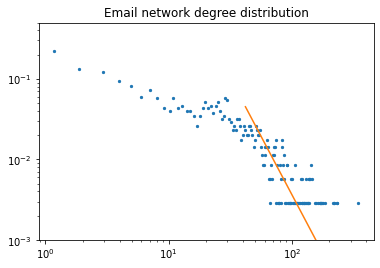

In [119]:
hist, bin_edges = np.histogram(degree_sequence, bins=1000, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
plt.scatter(bin_centers[hist > 0], hist[hist > 0], s=5)
plt.title('Email network degree distribution')

hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
x_space = np.linspace(hat_x_min, degree_sequence.max(), 100)
plt.plot(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
         label='Estimated PDF', c='tab:orange')
plt.xscale('log')
plt.yscale('log')
plt.ylim(0.001, 0.5);

### Task 6. QQ Plot (2 points)

It might be useful to draw a quantile-quantile plot (QQ plot) to compare empirical and theoretical distributions by the eye. Your task here is to generate Power Law observations by given parameters and compare theoretical and empirical quantiles.

Write a function `qqplot_data` that takes $\alpha$, $x_\min$, number of observations $n$ that will be generated and returns a tuple with two np.arrays: theoretical quantiles and empirical quantiles. Let quantiles be calculated for probabilities 0, 0.01, 0.02, ..., 0.99.

_Hint: to calculate an empirical quantile, use `np.quantile`_

In [27]:
def qqplot_data(alpha, x_min, n):
    quantiles = np.arange(0, 1, 0.01)
    theor = power_law_ppf(quantiles, alpha, x_min)
    data = power_law_generate(n, alpha, x_min)
    empir = np.quantile(data, quantiles)
    return theor, empir
    raise NotImplementedError()

In [28]:
x_min = 1
alpha = 3.5

theor100, empir100 = qqplot_data(alpha, x_min, 100)
theor200, empir200 = qqplot_data(alpha, x_min, 200)
theor1000, empir1000 = qqplot_data(alpha, x_min, 1000)
assert np.linalg.norm(theor1000 - empir1000) < np.linalg.norm(theor200 - empir200)
assert np.linalg.norm(theor200 - empir200) < np.linalg.norm(theor100 - empir100)

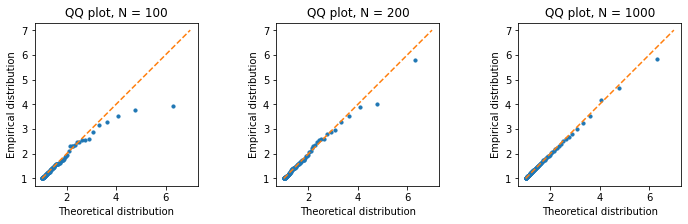

In [29]:
plt.figure(figsize=(12, 3))

plt.subplots_adjust(wspace=0.3)

plt.subplot(1, 3, 1)
plt.scatter(theor100, empir100, s=10)
plt.plot([1, 7], [1, 7], '--', c='tab:orange')
plt.title('QQ plot, N = 100')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')
plt.axis('square')

plt.subplot(1, 3, 2)
plt.scatter(theor200, empir200, s=10)
plt.plot([1, 7], [1, 7], '--', c='tab:orange')
plt.title('QQ plot, N = 200')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')
plt.axis('square')

plt.subplot(1, 3, 3)
plt.scatter(theor1000, empir1000, s=10)
plt.plot([1, 7], [1, 7], '--', c='tab:orange')
plt.title('QQ plot, N = 1000')
plt.xlabel('Theoretical distribution')
plt.ylabel('Empirical distribution')
plt.axis('square');